#Práctica 3, primera parte: Cifar100. Pablo Rodríguez Fernández.

En este archivo se encuentran los dos primeros apartados de la práctica 3, relativos a a la red BaseNet y el dataset Cifar100. Se separan del tercer apartado debido a las limitaciones de RAM de Colab.

#Preparativos

In [ ]:
#Importamos las bibliotecas necesarias
import numpy as np
from matplotlib import pyplot
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.datasets import cifar100

#Importamos las capas que se utilizaran en los modelos, así como elbackend de Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

#HIPERPARAMETROS A FIJAR
# TAMAÑO DE BATCH
batch_size = 128
# NÚMERO DE CLASES
num_classes = 25
# ÉPOCAS DE ENTRENAMIENTO: Numero de veces que iteramos sobre el conjunto de datos de entrenamiento enteros
epochs = 50

# DIMENSIONES DE ENTRADA DE LAS IMAGENES
img_rows, img_cols = 32, 32

# CARGAMOS LOS DATOS DE ENTRENAMIENTO Y TEST: x-> Imagenes, y-> Etiquetas
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#Solo vamos a trabajar con 25 clases
train_idx = np.isin(y_train, np.arange(num_classes))
train_idx = np.reshape(train_idx,-1)
x_train = x_train[train_idx]
y_train = y_train[train_idx]
  
test_idx = np.isin(y_test, np.arange(num_classes))
test_idx = np.reshape(test_idx, -1)
x_test = x_test[test_idx]
y_test = y_test[test_idx]

#Obtenemos el tamaño con el que vamos a trabajar
input_shape = (32,32,3)

# Transformamos los vectores de clases en matrices.
# Cada componente se convierte en un vector de ceros
# con un uno en la componente correspondiente a la
# clase a la que pertenece la imagen. Este paso es
# necesario para la clasificación multiclase en keras.
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)



En esta práctica se busca obtener experiencia en el uso de CNN utilizano Keras. Para ello, en esta primera parte se trabaja con la red BaseNet y el dataset CIFAR100.

CIFAR100 contiene imágenes de 100 clases diferentes, pero para facilitar el entrenamiento y que sea más rápido, nos restringiremos solamente a 25 clases (de ahí que *num_classes=25*).

En el fragmento de código anterior se cargan las librerías necesarias, las capas que se utlizarán para construir las redes, el dataset y se crean los conjuntos de training y de test.

Además, se fijan algunos de los hiperparámetros que utilizará la red durante el entrenamiento:


*   BATCH_SIZE = 128: Debe ser un múltiplo de 2 (para aprovechar al máximo la arquitectura de las GPU).
*   num_classes = 25, como ya se comentó.
*   epochs = 50: Número de veces que se pasa el conjunto de training entero por la red. En algún caso este parámetro será variado, siendo comentado cuando sea así.







# **Apartado 1: BaseNet en CIFAR100**

In [ ]:
# AQUI COMIENZA LA DESCRIPCION DEL MODELO DE RED NEURONAL QUE VAMOS A EMPLEAR
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 50)                2

El modelo BaseNet consta de dos módulos convolucionales (conv 5x5 + relu + maxPooling) , con 6 y 16 canales respectivamente, y dos capas lineales (*Dense* en la terminología de Keras). Las capas de activación no lineales *ReLu* se introducen como parámetro en las capas convolucionales, y el propio framework se encarga de ejecutarlas justo después de la convolución.

Con el método *summary* del modelo podemos ver un resumen de los parámetros de la red. Esta consta de muy pocos parámetros entrenables para ser una CNN (apenas 24000). Aún así, como se verá, llega a tener un rendimiento aceptable.

In [ ]:
# AQUI DEFINIMOS EL OPTIMIZADOR, LA FUNCION DE PERDIDA, Y LA METRICA
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
weights = model.get_weights()

Antes de entrenar el modelo, definir el optimizador que utilizará y compilarlo. En este caso, el optimizador a utilizar es *Adam* (recomendado por el profesor), y la función de pérdida a minimizar será *crossentropy*. Además, definimos que la métrica que queremos minimizar es el *Accuracy* del modelo.

Además, guardamos los pesos iniciales que tiene el modelo tras la compilación. Esto se realiza para poder asignárselos al modelo antes de cada entrenamiento. De no hacerlo, el entrenamiento se realizaría en base a los pesos obtenidos en entrenamientos anteriores. Si bien esto puede ser útil en determinados casos, se consideró que para que los resultados se vean más claros, solo se tenga en cuenta el último entrenamiento realizado por la red.

In [ ]:
#ENTRENAMOS: https://keras.io/api/models/model_training_apis/
model.set_weights(weights)
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.1)


Epoch 1/50
88/88 [==============================] - 9s 12ms/step - loss: 3.1041 - accuracy: 0.0934 - val_loss: 2.8656 - val_accuracy: 0.1816
Epoch 2/50
88/88 [==============================] - 1s 8ms/step - loss: 2.6740 - accuracy: 0.2264 - val_loss: 2.5573 - val_accuracy: 0.2584
Epoch 3/50
88/88 [==============================] - 1s 9ms/step - loss: 2.4874 - accuracy: 0.2865 - val_loss: 2.4532 - val_accuracy: 0.3088
Epoch 4/50
88/88 [==============================] - 1s 9ms/step - loss: 2.3894 - accuracy: 0.3130 - val_loss: 2.3401 - val_accuracy: 0.3288
Epoch 5/50
88/88 [==============================] - 1s 8ms/step - loss: 2.2872 - accuracy: 0.3405 - val_loss: 2.2821 - val_accuracy: 0.3320
Epoch 6/50
88/88 [==============================] - 1s 8ms/step - loss: 2.2086 - accuracy: 0.3613 - val_loss: 2.2486 - val_accuracy: 0.3496
Epoch 7/50
88/88 [==============================] - 1s 8ms/step - loss: 2.1372 - accuracy: 0.3782 - val_loss: 2.1644 - val_accuracy: 0.3680
Epoch 8/50
88/88 [=

En este fragmento de código se realiza el entrenamiento del modelo. Antes de nada, como se comentó anteriormente, se reestablecen los pesos de la red.

Para entrenar la red, debemos pasarle el conjunto de training y las etiquetas asociadas. Además, indicamos que el $10\%$ de los datos de training se dejen para validación. De esta manera, la red podrá comprobar cómo está aprendiendo sin tener que recurrir al conjunto de test (el cual nunca se debe utilizar durante el entrenamiento).

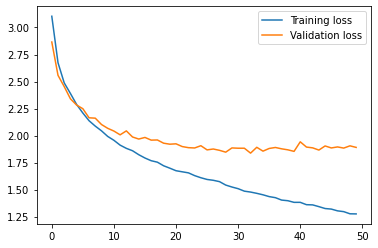

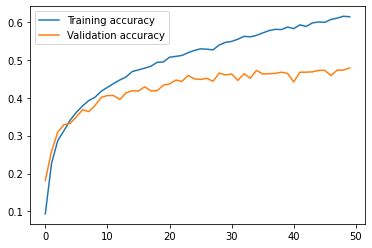

Test loss: 1.9275312423706055
Test accuracy: 0.4708000123500824


In [ ]:
# Esta función pinta dos gráficas, una con la evolución
# de la función de pérdida en el conjunto de train y
# en el de validación, y otra con la evolución de la
# accuracy en el conjunto de train y el de validación.
# Es necesario pasarle como parámetro el historial del
# entrenamiento del modelo (lo que devuelven las
# funciones fit() y fit_generator()).
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.legend(['Training loss', 'Validation loss'])
    pyplot.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    pyplot.plot(acc)
    pyplot.plot(val_acc)
    pyplot.legend(['Training accuracy','Validation accuracy'])
    pyplot.show()


mostrarEvolucion(hist)

# APLICAMOS EL TEST
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Una vez entrenada la red, procedemos a mostrar la evolución de la pérdida (*loss*) y la precisión (*accuracy*) de la red durante el entrenamiento, así como la precisión y pérdida obtenidas cuando se utiliza el modelo ya entrenado para realizar predicciones sobre el conjunto de test.

Si bien el entrenamiento se realizón 50 épocas,se puede ver como la precisión y la pérdida encuentran una asíntota alrededor de la época 30, en la cual podríamos dejar de entrenar ya que solo incrementamos el overfitting (el cual está muy presente en este modelo, ya que la pérdida y la precisión son mucho mejores en el entrenamiento). Sin embargo, en este caso se decidió dejar solamente con fines educativos, para que se viese claramente a partir de qué punto el modelo deja de mejorar y el entrenamiento pierde su efecto.

La precisión en el test es de alrededor del $45\%$. Si bien no es muy grande, no está mal teniendo en cuenta la sencillez del modelo, el cual se entrena en apenas 1 minutos (40 segundos si limitamos el entrenamiento a 30 épocas).

Aún así, es posible mejorarlo para lograr precisiones mucho mejores sin incrementar enormemente el tiempo de entrenamiento, como se verá en el apartado siguiente.

#**Apartado 2: Mejora del modelo BaseNet**

En este apartado se busca mejorar el modelo BaseNet introduciendo diversas modificaciones tanto en el propio modelo como en el proceso de entrenamiento. A continuación se listan las mejoras introducidas, las cuales serán comentadas posteriormente a medida que se vayan añadiendo:


*   Introducción de una capa de dropout
*   Capas de BatchNormalization
*   Modificación del bloque convolucional y uso de más convoluciones.
*   Aumento de datos
*   Early Stopping 




In [ ]:
#########################################################################
########################## Modelo #######################################
#########################################################################
from keras.layers import BatchNormalization,Activation

modelImprove = Sequential()
modelImprove.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape,
                 use_bias=False,
                 padding='same'))
modelImprove.add(Activation('relu'))
modelImprove.add(Conv2D(32, kernel_size=(3, 3),
                 use_bias=False))
modelImprove.add(BatchNormalization())
modelImprove.add(Activation('relu'))
modelImprove.add(MaxPooling2D(pool_size=(2, 2)))
modelImprove.add(Conv2D(64, kernel_size=(3, 3),
                        use_bias=False,
                        padding='same'))
modelImprove.add(Activation('relu'))
modelImprove.add(Conv2D(64, kernel_size=(3, 3),
                        use_bias=False))
modelImprove.add(BatchNormalization())
modelImprove.add(Activation('relu'))
modelImprove.add(MaxPooling2D(pool_size=(2, 2)))
modelImprove.add(Flatten())
modelImprove.add(Dropout(rate=0.3))
modelImprove.add(Dense(50, activation='relu'))
modelImprove.add(Dense(25, activation='softmax'))
# AQUI ACABA LA DESCRIPCION DEL MODELO

modelImprove.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        864       
                                                                 
 activation_20 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 30, 30, 32)        9216      
                                                                 
 batch_normalization_10 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                 

En primer lugar, introduje una capa de dropout con ratio=0.3. Esto significa que cada vez que el entrenamiento se encuentre en la capa lineal que está justo a continuación, aleatoriamente se apagarán el $30\%$ de las neuronas de esa capa. Esto provoca que éstas tengan que generalizar más, consiguiendo una mejora de 0.02 aproximadamente sin aumentar los tiempos de entrenamiento ni añadir parámetros a la red.

```
modelImprove.add(Dropout(rate=0.3))
modelImprove.add(Dense(50, activation='relu'))
```
Después de cada bloque convolucional se añadió una capa de Batch Normalization, situada antes de la activación ReLu. Estas capas se introducen para reducir el sobreajuste del modelo. Si bien existe una gran discusión sobre su utilidad real, tras realizar diversas pruebas (no incluirlas, incluirlas después de todas las convoluciones, incluirlas después de solo algunas, incluirlas antes de las capas lineales,etc), la mayor mejora se logró situándolas solamente al final de cada bloque convolucional. De esta manera se logró una mejora de otro 0.02 sin aumentar prácticamente tiempos de entrenamiento y añadiendo muy pocos parámetros a la red.

```
modelImprove.add(Conv2D(16, (5, 5),use_bias=False))
modelImprove.add(BatchNormalization())
modelImprove.add(Activation('relu'))
```

Cabe mencionar que en las capas que preceden a la normalización se fija el parámetro *use_bias=False*. Esto es debido a que la capa de normalización ya añade su propio bias, y si no se cancelaría con el bias introducido en la capa convolucional.

Una de las mayores mejoras introducidas fue la modificación de los bloques convolucionales y el aumento de la profundidad de la red (mayor número de bloques).

En primer lugar, modificamos el número de canales con los que se realizan las convoluciones. El primero pasa de 6 a 32, y el segundo, de 16 a 64. Este hecho mejora bastante el desempeño (ya que la red tiene más parámetros que aprender y por tanto puede ajustarse mejor a los datos), pero esto también provoca que aumente el tiempo de entrenamiento. Para intentar contrarrestar parcialmente este hecho, en lugar de utilizar los bloques de $$convolucion(5x5)+MaxPooling$$ se sustituyen estos bloques por $$convolucion(3x3)+convolucion(3x3)+MaxPooling$$

Además, en la primera convolución de cada bloque se fija "padding=same" para no perder dimensionalidad tan rápido. Recordemos que hacer 2 convoluciones 3x3 es similar a hacer una convolución 5x5, pero es más eficiente (utiliza un menor número de parámetros). Este hecho provoca que el tiempo de entrenamiento por epoch se duplique (de 1.2s a 2.4s), pero aumenta el desempeño de la red en casi un 0.1 (de 0.5 a 0.6 prácticamente):


```
modelImprove.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape,
                 use_bias=False,
                 padding='same'))
modelImprove.add(Activation('relu'))
modelImprove.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape,
                 use_bias=False))
modelImprove.add(BatchNormalization())
modelImprove.add(Activation('relu'))
modelImprove.add(MaxPooling2D(pool_size=(2, 2)))
```
Ahora se puede ver cómo la capa de Batch Normalization solo se añade tras la segunda convolución de cada bloque (la última), y no en la primera, como se comentó antes.

En resumen, el modelo quedaría de la siguiente manera:

$$\begin{array}{ccccc}
\textbf{Layer No.} & \textbf{Layer Type} & \textbf{Kernel Size} & \textbf{Dimension} & \textbf{Channels} \\
1                  & Conv2D              & 3                    & 32 | 32            & 32                \\
2                  & ReLu                & -                    & 32 | 32            & -                 \\
3                  & Conv2D              & 3                    & 32 | 30            & 32                \\
4                  & BatchNormalization  & -                    & 30|30              & -                 \\
5                  & MaxPooling2D        & -                    & 30|15              & -                 \\
6                  & Conv2D              & 3                    & 15|15              & 64                \\
7                  & ReLu                & -                    & 15|15              & -                 \\
8                  & Conv2D              & 3                    & 15|13              & 64                \\
9                  & BatchNormalization  & -                    & 13|13              & -                 \\
10                 & MaxPooling2D        & -                    & 13|6               & -                 \\
11                 & Flatten             & -                    & 6|2034             & -                 \\
12                 & Dropout             & -                    & 2034|2034          & -                 \\
13                 & Linear              & -                    & 2034|50            & -                 \\
14                 & ReLu                & -                    & 50|50              & -                 \\
15                 & Linear              & -                    & 50|25              & -                 \\
16                 & Softmax             & -                    & 25|25              & -                
\end{array}$$



In [ ]:
#########################################################################
########################## Aumento de datos #############################
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=20,
                             validation_split=0.1)
datagen_valid = ImageDataGenerator(validation_split=0.1)


Si se entrena el modelo anterior, la precisión mejora hasta casi el $60\%$ en el conjunto de prueba, pero las gráficas muestran que existe un gran overfitting. ¿Cómo solucionar esto?

Una posible manera es aumentar el conjunto de training, realizando pequeñas modificaciones a las imágenes, como son rotaciones (de hasta 20 grados) o volteando las imágenes. Estas tranformaciones reducen enormemente el sobreajuste, además de incrementar aún más la precisión (sube hasta el $65\%$).

Sin embargo, el tiempo de entrenamiento crece mucho, hasta casi los 6 minutos y medio. Por esta misma razón, el modelo que se ejecutará no incluirá esta aumento de datos (así el tiempo de entrenamiento se reduce a las 2-3 minutos). Igualmente, al final del documento se incluye un **Anexo** con el entrenamiento utilizando estos datos así como sus resultados, por si se quiere comprobar este hecho.

Cabe mencionar que es posible realizar más transformaciones sobre los datos, pero cada una de ellas incrementa el tiempo de entrenamiento y además no son siempre efectivas. Por ejemplo,se probó a realizar zoom en las imágenes (*zoom_range=0.2*), pero no provocaba ninguna mejora. También se intentó realizar modificaciones en los colores, pero Keras no ofrece ninguna función que permita modificar solo estos valores sin que se influya en la intensidad (lo cual no se debería tocar, ya que es lo que define, entre otras cosas, los bordes de los objetos), con lo cual se descartó también.


In [ ]:
#########################################################################
######################### Compilacion del modelo ########################
#########################################################################
modelImprove.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
weightsImprove = modelImprove.get_weights()

Epoch 1/50
88/88 [==============================] - 3s 27ms/step - loss: 2.9425 - accuracy: 0.1553 - val_loss: 3.1572 - val_accuracy: 0.0424
Epoch 2/50
88/88 [==============================] - 2s 23ms/step - loss: 2.4876 - accuracy: 0.2858 - val_loss: 3.0617 - val_accuracy: 0.1192
Epoch 3/50
88/88 [==============================] - 2s 23ms/step - loss: 2.1634 - accuracy: 0.3698 - val_loss: 3.0339 - val_accuracy: 0.1624
Epoch 4/50
88/88 [==============================] - 2s 23ms/step - loss: 1.9108 - accuracy: 0.4341 - val_loss: 3.1128 - val_accuracy: 0.1608
Epoch 5/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7054 - accuracy: 0.4860 - val_loss: 2.2261 - val_accuracy: 0.3456
Epoch 6/50
88/88 [==============================] - 2s 22ms/step - loss: 1.5382 - accuracy: 0.5308 - val_loss: 2.0536 - val_accuracy: 0.3952
Epoch 7/50
88/88 [==============================] - 2s 23ms/step - loss: 1.4311 - accuracy: 0.5594 - val_loss: 1.7428 - val_accuracy: 0.4688
Epoch 8/50
88

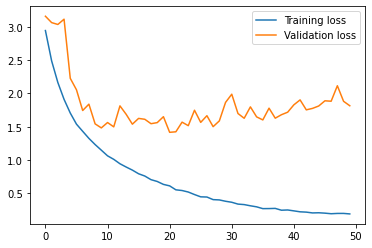

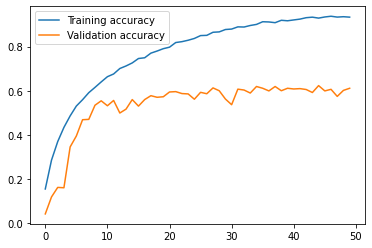

Test loss: 1.7756130695343018
Test accuracy: 0.6159999966621399


In [ ]:
#########################################################################
########################## Entrenamiento ################################
#########################################################################
modelImprove.set_weights(weightsImprove)

#Entrenamiento sin DataAugmentation

histImprove = modelImprove.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.1)

#########################################################################
########################## Resultados ###################################
#########################################################################

mostrarEvolucion(histImprove)

# APLICAMOS EL TEST
scoreImp = modelImprove.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scoreImp[0])
print('Test accuracy:', scoreImp[1])



Como se comentó anteriormente, se ejecuta el modelo sobre el conjunto de traning sin el aumento de datos para reducir el tiempo de entrenamiento, aunque el resultado sea sensiblemente inferior.

Al entrenar este modelo se puede ver como la precisión aumenta enormemente en comparación con la versión básica de BaseNet, pero se produce un sobreajuste considerable.

Cabe mencionar que la gran cantidad de picos es debida a la capa de dropout. Dicha capa al final provoca que en cada época la red sea diferente, con lo cual la componente aleatoria del entrenamiento aumenta. Eliminando esta capa se comprobó que los picos practicamente desaparecen, pero también disminuye la precisión del modelo.

#Anexo Apartado 2: Entrenamiento con aumento de datos

Epoch 1/50
88/88 [==============================] - 8s 84ms/step - loss: 3.0646 - accuracy: 0.1206 - val_loss: 3.2163 - val_accuracy: 0.0416
Epoch 2/50
88/88 [==============================] - 7s 82ms/step - loss: 2.7670 - accuracy: 0.2121 - val_loss: 3.2338 - val_accuracy: 0.0632
Epoch 3/50
88/88 [==============================] - 7s 83ms/step - loss: 2.4954 - accuracy: 0.2893 - val_loss: 3.0219 - val_accuracy: 0.1304
Epoch 4/50
88/88 [==============================] - 7s 82ms/step - loss: 2.2915 - accuracy: 0.3324 - val_loss: 2.9015 - val_accuracy: 0.1456
Epoch 5/50
88/88 [==============================] - 7s 80ms/step - loss: 2.1446 - accuracy: 0.3734 - val_loss: 2.5252 - val_accuracy: 0.2568
Epoch 6/50
88/88 [==============================] - 7s 82ms/step - loss: 1.9963 - accuracy: 0.4116 - val_loss: 2.1190 - val_accuracy: 0.3752
Epoch 7/50
88/88 [==============================] - 7s 83ms/step - loss: 1.8869 - accuracy: 0.4307 - val_loss: 1.9141 - val_accuracy: 0.4096
Epoch 8/50
88

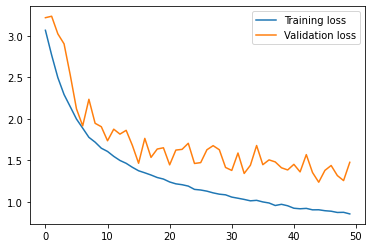

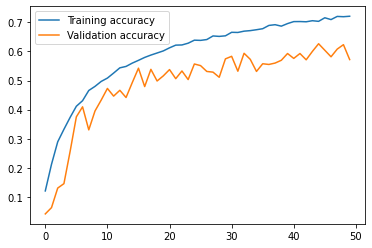

Test loss: 1.33082115650177
Test accuracy: 0.61080002784729


In [ ]:
modelImprove.set_weights(weightsImprove)

#Entrenamiento con DataAugmentation
histImprove = modelImprove.fit(
                              datagen.flow(x_train, y_train, batch_size=batch_size,subset="training"),
                              validation_data=datagen_valid.flow(x_train,y_train, subset="validation"),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=1,
                               )

mostrarEvolucion(histImprove)

# APLICAMOS EL TEST
scoreImp = modelImprove.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scoreImp[0])
print('Test accuracy:', scoreImp[1])
